In [99]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from collections import defaultdict
import requests_cache
from fp.fp import FreeProxy
from retry_requests import retry
import openmeteo_requests
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import joblib


In [ ]:
DATA_DIR = Path("data") 
OUTPUT_PREPARED_FILE = DATA_DIR / "ready2use_region_electricity.csv"
df = pd.read_csv(OUTPUT_PREPARED_FILE, parse_dates=["datetime"], index_col="datetime")

Output file already exists. Exiting.


Прогнозувати будемо energy_deficit_adj(t+1…t+24) погодинно, по регіонах. Контекстне вікно 7 днів як в GNN

список фіч:
"demand_ua_adj","generation_ua_adj","energy_deficit_adj","alert_active", "isDamaged", "temperature","humidity","precipitation","snowfall","wind_speed","wind_gusts","cloud_cover","surface_pressure",

P.S. 25лямів рядків вийшло +- 1гб

Година доби - циклічна змінна (23.00->00.00), нейромережа бачить різкий розрив, якого фізично не існує, тому модель не буде розуміти добових патернів. Для цього робимо проекцію на коло - представляємо годину як точку на одиничному колі, тоді 23 та 00 будуть не далеко як до цього, а поруч один до одного, тобто модель бачить добовий цикл. робимо це через синуси та косинуси)

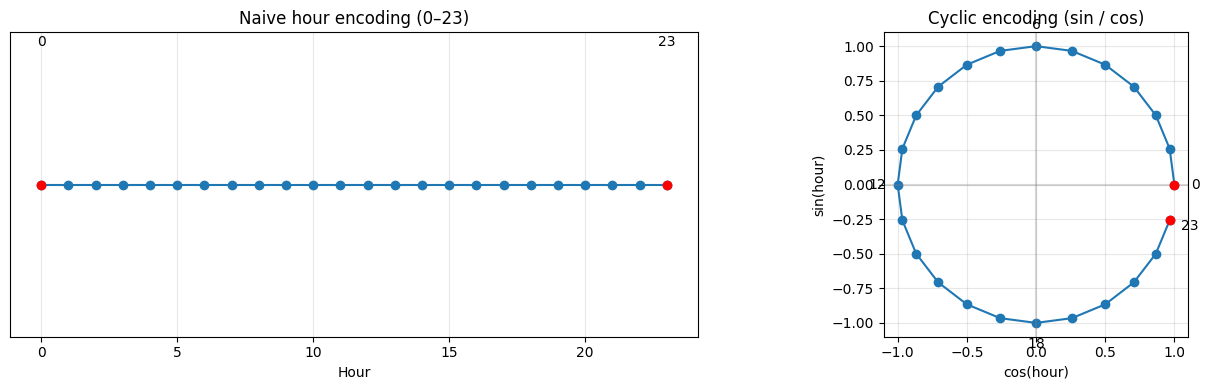

In [103]:
hours = np.arange(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(hours, np.zeros_like(hours), "o-")
axes[0].scatter([23, 0], [0, 0], color="red", zorder=5)

axes[0].text(23, 0.05, "23", ha="center")
axes[0].text(0, 0.05, "0", ha="center")

axes[0].set_title("Naive hour encoding (0–23)")
axes[0].set_xlabel("Hour")
axes[0].set_yticks([])
axes[0].grid(alpha=0.3)

theta = 2 * np.pi * hours / 24
x = np.cos(theta)
y = np.sin(theta)

axes[1].plot(x, y, "o-")
axes[1].scatter([x[23], x[0]], [y[23], y[0]], color="red", zorder=5)

for h in [0, 6, 12, 18, 23]:
    axes[1].text(x[h]*1.15, y[h]*1.15, str(h), ha="center", va="center")

axes[1].axhline(0, color="gray", alpha=0.3)
axes[1].axvline(0, color="gray", alpha=0.3)
axes[1].set_aspect("equal")

axes[1].set_title("Cyclic encoding (sin / cos)")
axes[1].set_xlabel("cos(hour)")
axes[1].set_ylabel("sin(hour)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [105]:
runTraining = True

In [106]:
T_CONTEXT = 24 * 7 # 7 днів
HORIZON   = 24 # 24 години вперед

FEATURES = [
    "demand_ua_adj","generation_ua_adj","energy_deficit_adj","alert_active",
    "isDamaged","temperature","humidity","precipitation","snowfall","wind_speed",
    "wind_gusts","cloud_cover","surface_pressure","hour_sin","hour_cos",
]

TARGET = "energy_deficit_adj"

MODEL_DIR = Path("serialized")
MODEL_DIR.mkdir(exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def add_time_features(df):
    df = df.copy()
    hour = df["timestamp_utc"].dt.hour
    df["hour_sin"] = np.sin(2 * np.pi * hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * hour / 24)
    return df

def build_sequences(df, features, target):
    """
    X: [N, T_CONTEXT, F]
    y: [N, HORIZON]
    """
    X, y = [], []

    values = df[features].values
    target_vals = df[target].values

    for t in range(T_CONTEXT, len(df) - HORIZON):
        X.append(values[t - T_CONTEXT : t])
        y.append(target_vals[t : t + HORIZON])

    return np.array(X), np.array(y)


class LoadGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, HORIZON)
        )

    def forward(self, x):
        # x: [B, T, F]
        out, _ = self.gru(x)
        h_last = out[:, -1, :]   # [B, hidden]
        return self.head(h_last) # [B, HORIZON]


In [108]:
from torch.utils.data import Dataset

class LoadDataset(Dataset):
    def __init__(self, df, features, target,
                 t_context, horizon,
                 scaler=None):
        self.df = df.reset_index(drop=True)
        self.features = features
        self.target = target
        self.T = t_context
        self.H = horizon
        self.scaler = scaler

        self.valid_idx = range(self.T, len(df) - self.H)

    def __len__(self):
        return len(self.valid_idx)

    def __getitem__(self, idx):
        t = self.valid_idx[idx]

        X = self.df.loc[t - self.T:t - 1, self.features].values
        y = self.df.loc[t:t + self.H - 1, self.target].values

        if self.scaler is not None:
            X = self.scaler.transform(X)

        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )


In [ ]:
df = ua_df_merged.copy()
df = df.sort_values("timestamp_utc").reset_index(drop=True)
df = add_time_features(df)

# ===============================
# BUILD SEQUENCES
# ===============================
X, y = build_sequences(df, FEATURES, TARGET)

print("Total samples:", len(X))
print("X shape:", X.shape)
print("y shape:", y.shape)

# ===============================
# TIME-BASED 80 / 20 SPLIT
# ===============================
N = len(X)
split_idx = int(0.8 * N)

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print("Train samples:", len(X_train))
print("Val samples:", len(X_val))

scaler = StandardScaler()

# fit ONLY on train
X_train_2d = X_train.reshape(-1, len(FEATURES))
scaler.fit(X_train_2d)

def scale(X):
    X2 = X.reshape(-1, len(FEATURES))
    X2 = scaler.transform(X2)
    return X2.reshape(X.shape)

X_train = scale(X_train)
X_val   = scale(X_val)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

model = LoadGRU(input_dim=len(FEATURES)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [ ]:
from torch.utils.data import DataLoader

train_ds = LoadDataset(
    df_train, FEATURES, TARGET,
    T_CONTEXT, HORIZON,
    scaler=scaler
)

val_ds = LoadDataset(
    df_val, FEATURES, TARGET,
    T_CONTEXT, HORIZON,
    scaler=scaler
)

train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False
)


In [ ]:
@torch.no_grad()
def predict_next_24h(df_last_window):
    """
    df_last_window: DataFrame з останніми T_CONTEXT годинами
    """
    df_last_window = add_time_features(df_last_window)

    X = df_last_window[FEATURES].values
    X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32, device=device)

    X = X.unsqueeze(0)  # [1, T, F]

    pred = model(X)     # [1, 24]
    return pred.squeeze(0).cpu().numpy()
